# Voxel time courses

When we have a 4D image, we can think of the data in several ways.  For
example the data could be:

* A series of 3D volumes (slicing over the last axis);

* A collection of 1D voxel time courses (slicing over the first three axes).

For this notebook you will need:

* [ds114 FMRI image]({{ site.url }}{{ site.baseurl }}/data/ds114_sub009_t2r1.nii).
* [ds114 stimulus file]({{ site.url }}{{ site.baseurl }}/data/ds114_sub009_t2r1_cond.txt).

In [1]:
# Our usual set-up
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Display array values to 4 digits of precision
np.set_printoptions(precision=4, suppress=True)

We load a 4D file:

In [2]:
import nibabel as nib
img = nib.load('ds114_sub009_t2r1.nii')
img.shape

(64, 64, 30, 173)

We drop the first volume; as you remember, the first volume is very different
from the rest of the volumes in the series:

In [3]:
# Drop the first volume
data = img.get_data()
data = data[..., 1:]
data.shape

(64, 64, 30, 172)

We can think of this 4D data as a series of 3D volumes.  That is the way we
have been thinking of the 4D data so far:

In [4]:
# This is slicing over the last (time) axis
vol0 = data[..., 0]
vol0.shape

(64, 64, 30)

We can also index over the first three axes.  The first three axes in this
array represent space.

* The first axis goes from right to left (0 index value means right, 63 means
  left);

* The second axis goes from back to front (0 index value means back, 63 means
  front);

* The third axes goes from bottom to top (0 means bottom, 29 means top).

If you give me index values for these first three axes, you have given me a
*coordinate* in the first three axes of the array.

For example, you could give me an index tuple for the first three axes like
this: `(42, 32, 19)`.  The first index of 42 refers to a position towards
the left of the brain (> 31).  The second index of 32 refers to a position
almost in the center front to back.  The last index of 19 refers to a position
a little further towards the top of the brain – in this image.

This coordinate therefore refers to a particular part of the image:

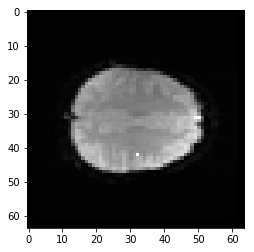

In [5]:
# Where is this in the brain?
mean_data = np.mean(data, axis=-1)
# Make a nice bright dot in the right place
mean_data[42, 32, 19] = np.max(mean_data)
plt.imshow(mean_data[:, :, 19], cmap='gray', interpolation='nearest')

If I slice into the data array with these coordinates, I will get a vector,
with the image value at that position (43, 32, 19), for every point in time:

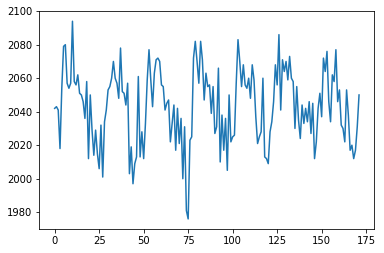

In [6]:
# This is slicing over all three of the space axes
voxel_time_course = data[42, 32, 19]
voxel_time_course.shape
plt.plot(voxel_time_course)

We could call this a “voxel time course”.

We might want to do ordinary statistical type things with this time course.
For example, we might want to correlate this time course with a measure of
whether the subject was doing the task or not.

This measure will have 1 for each volume (time point) where the subject was
doing the task, and 0 for each volume where the subject was at rest.

We call this a “neural” time course, because we believe that the nerves in the
relevant brain area will switch on when the task starts (value = 1) and then
switch off when the task stops (value = 0).

To get this on-off measure, we first need to load the stimulus file:

In [7]:
def events2neural(task_fname, tr, n_trs):
    """ Return predicted neural time course from event file `task_fname`

    Parameters
    ----------
    task_fname : str
        Filename of event file
    tr : float
        TR in seconds
    n_trs : int
        Number of TRs in functional run

    Returns
    -------
    time_course : array shape (n_trs,)
        Predicted neural time course, one value per TR
    """
    task = np.loadtxt(task_fname)
    # Convert onset, duration seconds to TRs
    task[:, :2] = task[:, :2] / tr
    ons_dur = task[:, :2]
    # Neural time course from onset, duration, amplitude for each event
    time_course = np.zeros(n_trs)
    for onset, duration, amplitude in task:
        # Make onset and duration integers
        onset = int(round(onset))
        duration = int(round(duration))
        time_course[onset:onset + duration] = amplitude
    return time_course

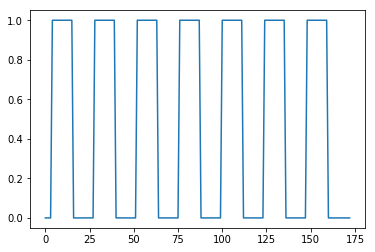

In [8]:
# Use the new function to load the event traces
TR = 2.5  # time between volumes
n_trs = img.shape[-1]  # The original number of TRs
neural = events2neural('ds114_sub009_t2r1_cond.txt', TR, n_trs)
plt.plot(neural)

Here we plot the voxel time course against this neural prediction:

(-0.1, 1.1)

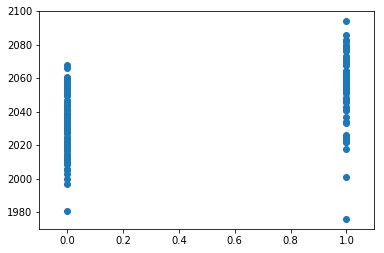

In [9]:
# Plot the neural prediction against the data
neural = neural[1:]
# Notice the 'o' to specify the "line marker"
plt.plot(neural, voxel_time_course, 'o')
# Set the axis limits to give space on left and right
axis = plt.gca()
axis.set_xlim(-0.1, 1.1)

We can look at the correlation between the on-off prediction and the voxel
time course:

In [10]:
# Correlate the neural time course with the voxel time course
np.corrcoef(neural, voxel_time_course)

array([[ 1.    ,  0.5429],
       [ 0.5429,  1.    ]])